In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from gproc.elliptic import ess_samples_probit
from gproc.metropolis_hastings import mh, mh_step
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse
from gproc.approx_marginal_is import importance_sampler
from gproc.joint_sampler import joint_sampler

In [2]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
y, prob_y, f = sample_at_x(x, kernel_fcn = squared_exponential, kernel_params = {'lengthscale': 1, 'variance': 3})

th_0 = np.array([1, 1])
gram = squared_exponential(x, x, lengthscale = th_0[0], variance = th_0[1])
inverse_gram = chol_inverse(gram)

In [3]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-23.0580497209566

In [5]:
f_arr, th_arr, marg_arr, acc_rate = joint_sampler(10000, y, x, th_0, marg_0, cov = 0.1*np.eye(th_0.shape[0]), N_imp = 64, burn_in = 50, verbose = True)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [09:12<00:00, 18.09it/s]


In [6]:
acc_rate*100

23.48

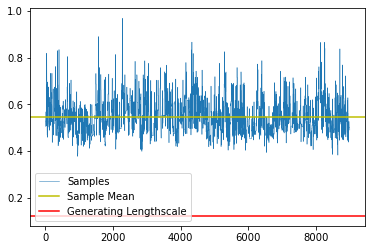

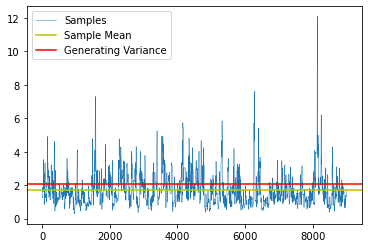

In [7]:
burn_in = 1000

plt.plot(np.exp(th_arr[burn_in:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = .35**2, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[burn_in:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 2.08, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()

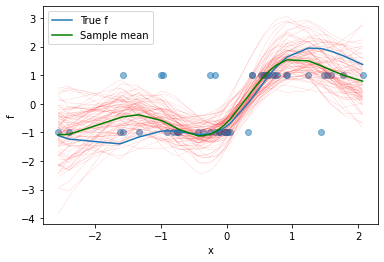

In [8]:
sort_ix = np.argsort(x.reshape(-1))

plt.xlabel('x')
plt.ylabel('f')
for i in range(burn_in, f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr[burn_in:, :].mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()